In [2]:
###
#  FUTON Model MDP + Q-Learning Creation Script
#  A Research Project conducted by Noah Dunn 
###

# Import the standard tools for working with Pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shelve
# Import the MDP toolbox that contains a method for conducting Q-Learning
# Tool can be found here: https://github.com/sawcordwell/pymdptoolbox
# Documentation for the tool can be found here 
import mdptoolbox

In [3]:
#  The Data File that will be used to conduct the experiments
patientdata = pd.read_csv("G:/MIMIC-ALL/MIMIC-PATIENTS/patient_data_modified.csv")

In [4]:
### 
#  An MDP, or Markov Decision Process is used to model relationships between various states and actions.
#  A state can be thought of in medical solution as a patient's diagnosis based on current vitals and state of being. 
#  An action can be thought of as a change in current diagnosis based on one of those vitals.
#  The inspirations for the bulk of this code came from Komorowksi's AI Clinician which can be found 
#  here: https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_core_160219.m
###

###
# Begin by establishing some global variables for use in the MDP creation
###
mdp_count = 500            # The number of repititions we want/count of MDPs we need to create 
clustering_iter = 32       # The number of times clustering will be conducted
cluster_sample = 0.25      # Proportion of the data used for clustering
gamma = 0.99               # How close we desire clusters to be in similarity (Percentage)
transition_threshold = 5   # The cutoff value for the transition matrix
final_policies = 1         # The number of policies we would like to end up with
state_count = 750          # The number of distinct states
action_count = 5           # Number of actions per state (reccommended 2 to 10)
crossval_iter = 10         # Number of crossvalidation runs (Default is 80% Train, 20% Test)

In [5]:
###
# Data structures to hold our interim data
###

# Create the structures and fill them with NaN values
optimal_actions = np.empty((state_count + 2, mdp_count,))  # Not sure the significance of the 2 yet
optimal_actions[:] = np.nan


model_data = np.empty((mdp_count*2, 30,))
model_data[:] = np.nan

bestmodels_data = np.empty((mdp_count, 15))

In [6]:
# Grab list of unique patient ICU stay IDs
icu_ids = patientdata['icustayid'].unique()
# Number of patients to be used for states
id_count = icu_ids.size
print(id_count)

# Create a data structure to representing all patients
patient_idxs = np.empty((id_count, mdp_count,))
patient_idxs[:] = np.nan

21463


In [7]:
# All our columns are broken up into 3 distinct categories:
# 1. Binary values (0 or 1)
# 2. Standard Ranges (Plain old Integers + Decimals)
# 3. Logarthmic Values (columnvalue = log(columnvalue))

colbin = ['gender','mechvent','max_dose_vaso','re_admission', 'qSOFAFlag', 'SOFAFlag']
colnorm = ['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance', 'qSOFA'];
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','input_total','input_4hourly','output_total','output_4hourly'];

# Create seperate dataframes for each of the columns
colbin_df = patientdata[colbin]
colnorm_df = patientdata[colnorm]
collog_df = patientdata[collog]

# Let's make sure we have what we need
print(colbin_df, "\n", colnorm_df, "\n", collog_df)

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag
0            0         1            0.0             0          1         0
1            0         1            0.0             0          1         1
2            0         1            0.0             0          1         1
3            0         1            0.0             0          1         1
4            0         1            0.0             0          1         1
...        ...       ...            ...           ...        ...       ...
238325       0         0            0.0             0          1         0
238326       0         0            0.0             0          1         0
238327       0         0            0.0             0          1         0
238328       0         0            0.0             0          1         0
238329       0         0            0.0             0          1         0

[238330 rows x 6 columns] 
                 age  Weight_kg        GCS         HR       SysBP     Me

In [8]:
# Rearrange the dataframe in order of binary, normal, and log data from left to right
MIMIC_raw = pd.concat([colbin_df, colnorm_df, collog_df], axis=1)
print(MIMIC_raw) 

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0            0         1            0.0             0          1         0   
1            0         1            0.0             0          1         1   
2            0         1            0.0             0          1         1   
3            0         1            0.0             0          1         1   
4            0         1            0.0             0          1         1   
...        ...       ...            ...           ...        ...       ...   
238325       0         0            0.0             0          1         0   
238326       0         0            0.0             0          1         0   
238327       0         0            0.0             0          1         0   
238328       0         0            0.0             0          1         0   
238329       0         0            0.0             0          1         0   

                age  Weight_kg        GCS         HR  ...    BU

In [9]:
# We want a Z-Score for every item. This a measure of variance to see how far a value is from the mean

# Scipy provides a library to execute this kind of thing
from scipy.stats import zscore
# We need to normalize binaries to -0.5 and 0.5 for later use
MIMIC_zscores = MIMIC_raw

# No need for the zscore algorithm here, -0.5 and 0.5 suffice
MIMIC_zscores[colbin] = MIMIC_zscores[colbin] - 0.5

# Recall these columns are logarithmic, so they needed converted back for proper Z-Scoring (+ 0.1 to avoid log(0))
MIMIC_zscores[collog] = np.log(MIMIC_zscores[collog] + 0.1).apply(zscore)

# Normal column requires no modifications. Z-Scores are calculated as normal
MIMIC_zscores[colnorm] = MIMIC_zscores[colnorm].apply(zscore)
print(MIMIC_zscores)

# We want Re Admission and fluid intake scaled Similarly to the other variables
MIMIC_zscores['re_admission'] = np.log(MIMIC_zscores['re_admission'] + 0.6)
# Apply a scalar to fluid intake
MIMIC_zscores['input_total'] = 2 * MIMIC_zscores['input_total']

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5           -0.5          -0.5        0.5      -0.5   
1         -0.5       0.5           -0.5          -0.5        0.5       0.5   
2         -0.5       0.5           -0.5          -0.5        0.5       0.5   
3         -0.5       0.5           -0.5          -0.5        0.5       0.5   
4         -0.5       0.5           -0.5          -0.5        0.5       0.5   
...        ...       ...            ...           ...        ...       ...   
238325    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238326    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238327    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238328    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238329    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   

             age  Weight_kg       GCS        HR  ...       BUN 

In [10]:
### The main loop to generate all possible models

num_rows = id_count  # Total Number of Patients to divy data up
testing_flag = 1     # The random number we use to identify a patient used for testing

# TODO: Change this to 1 in MDP_COUNT
#for model in range(1, 2): #mdp_count):
train_ids = []       # A list containing all training ids from the icu_ids list
test_ids =[]         # A list containing all testing ids from the icu_ids list

# We want approximate 20% test, 80% train, so we random numbers 1-5
# 1s Represent data points that will be used to test, 2-5 will be used to train
group_ids = pd.DataFrame([int(np.floor(5 * np.random.random() + 1)) for i in range(1, id_count + 1)])
icu_pair_set = pd.concat([pd.DataFrame(icu_ids), group_ids], axis=1, sort=False)
icu_pair_set.columns = ['id', 'fil_val']
train_ids =  icu_pair_set[icu_pair_set['fil_val'] != testing_flag]
test_ids = icu_pair_set[icu_pair_set['fil_val'] == testing_flag]

# We want to insure that the testing patients + training patients = total patients
if (train_ids['id'].size + test_ids['id'].size) != id_count:
    print("The testing and training set do not add up to the total set")
    exit()

# Percentage for testing should be about 20%, Training about 80%
print("Testing Percentage: " + str((test_ids['id'].size / id_count)))
print("Training Percentage: " + str((train_ids['id'].size / id_count)))

# After grabbing all the IDs, we want to flag all the rows that are train or test
train_flag = patientdata['icustayid'].isin(train_ids['id'])
test_flag = patientdata['icustayid'].isin(test_ids['id'])

import pickle
# Temporarily write train_flag for later use DELETE LATER
with open('sample_train.txt', 'wb') as fp:
    pickle.dump(train_flag, fp)

#Validating that all data is being selected, and that the train and test sets are perfect opposites
if patientdata['icustayid'].size != train_flag.size or not((train_flag.equals(~test_flag))):
    print("Not all rows were grabbed properly, there is something wrong with the split")
    exit()

Testing Percentage: 0.2036062060289801
Training Percentage: 0.79639379397102


In [11]:
# Seperate the Z-Scores for the training set and the testing set
train_zscores = MIMIC_zscores[train_flag]
test_zscores = MIMIC_zscores[test_flag]

# Validate all data is selected
if(train_zscores.size + test_zscores.size != MIMIC_zscores.size):
    print("The Z-Scores are all evenly distributed")
    exit()

    
# The blocs of relevance in order based on the train and test set
# These will be used to build relevant data frames later down
train_blocs = patientdata[train_flag]['bloc']
test_blocs = patientdata[test_flag]['bloc']

# Doing the same with the patient ids
train_id_list = patientdata[train_flag]['icustayid']
test_id_list = patientdata[test_flag]['icustayid']

# Grabbing the boolean values for the patients who died within 90 days in the training set
train_90d = patientdata[train_flag]['mortality_90d']

In [12]:
# Next, we want to sample the existing training set to only pick cluster_sample percent to use

# We want to flag all the data points in the train_zscores set that will be used to create the MDP

# Note: len(train_zscores.index) is the fastest way to get the number of rows in a dataframe in pandas

# Additional Note: np.floor(np.random.random() + cluster_sample) is a computationally speedy way to get an approximate
# percentage sample from a proportion value (cluster_sample). If cluster sample is 0.25, approximately 25% of the values
# will be flagged as a 1, making it into the sample training set
sample_train_flags = [bool(np.floor(np.random.random() + cluster_sample)) for i in range(len(train_zscores.index))]

# It's good to know how much of the data was selected as sample
print("Proportion of Train Data used for the Sample: " + str(sample_train_flags.count(True)/len(sample_train_flags)))

# The actual set to use
sample_train_set = train_zscores[sample_train_flags]

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('train_zscores.txt', 'wb') as fp:
    pickle.dump(train_zscores, fp)

Proportion of Train Data used for the Sample: 0.2496938603158517


In [ ]:
# Do Not Run the following code block if temporarily troubleshooting
# It takes a long time and there is a checkpoint system in place 

In [145]:
# In order to prepare a proper set of states, we want to use k-means clustering to group various patients into 
# distinct states based on Z-Scores

# K-Means or K-Means++ is a technique used to condense very diverse and sparse data into similar groups called 'clusters'
# The K-means algorithm will create k clusters from N data points. In the case of this research,
# the algorithm divides patients into groups that have similar data (age, blood pressure, etc..) and creates a faux 'point'
# at the center of that particular clustering of data


# Skikit offers a solution to perform K-Means++ clustering
from sklearn.cluster import KMeans
# The KMeans takes three 'settings' arguments
# 1. n_clusters: The number of clusters (later to be used as states), that we desire the algorithm to produce
# this value has been preset to state_count which is 750
# 2. max_iter: How many times each round of k-means clustering will make adjustments, set at 10,000 in my case
# 3. n_init: The number of max_iter batches that will be conducted in a row. The best of these will be chosen
# and saved in the variable clusters_models
clusters_models = KMeans(n_clusters=state_count, max_iter=10000, n_init=clustering_iter).fit(sample_train_set)
print(clusters_models.labels_)
print(clusters_models.cluster_centers_)

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('cluster_labels.txt', 'wb') as fp:
    pickle.dump(clusters_models.labels_, fp)
with open('cluster_centers.txt', 'wb') as fp:
    pickle.dump(clusters_models.cluster_centers_, fp)

[457 317 134 ... 427 427 349]
[[ 4.09836066e-02  3.19672131e-01 -1.97557377e-01 ...  6.83318018e-01
   9.82620620e-02 -1.33184787e-01]
 [ 1.51515152e-01 -3.78787879e-01 -4.93090909e-01 ...  3.89758578e-01
   3.61326177e-01  5.01574931e-01]
 [-3.46944695e-17 -4.72222222e-01 -5.00000000e-01 ... -6.70717127e-01
   1.85758170e-01 -1.85290276e+00]
 ...
 [-1.25000000e-01 -3.33333333e-01 -4.97916667e-01 ... -2.83927555e-01
   6.14615492e-01  5.56076190e-01]
 [-2.63157895e-02 -4.47368421e-01 -5.00000000e-01 ... -1.52106461e+00
  -1.83957232e+00 -1.40553964e+00]
 [-1.05263158e-01  3.15789474e-01  3.98526316e-01 ...  9.70609632e-01
  -2.91374122e-01 -2.61021581e-01]]


In [13]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Read these values back in from being saved to file
cluster_values = []
cluster_labels = [] 
train_zscores = []

with open ('cluster_centers.txt', 'rb') as fp:
    cluster_values = pickle.load(fp)
with open ('cluster_labels.txt', 'rb') as fp:
    cluster_labels = pickle.load(fp)
with open ('train_zscores.txt', 'rb') as fp:
    train_zscores = pickle.load(fp)
    
print(cluster_values, "\n", "Dimensions: ", len(cluster_values)," x ", len(cluster_values[0]), "\n", train_zscores)

[[ 4.09836066e-02  3.19672131e-01 -1.97557377e-01 ...  6.83318018e-01
   9.82620620e-02 -1.33184787e-01]
 [ 1.51515152e-01 -3.78787879e-01 -4.93090909e-01 ...  3.89758578e-01
   3.61326177e-01  5.01574931e-01]
 [-3.46944695e-17 -4.72222222e-01 -5.00000000e-01 ... -6.70717127e-01
   1.85758170e-01 -1.85290276e+00]
 ...
 [-1.25000000e-01 -3.33333333e-01 -4.97916667e-01 ... -2.83927555e-01
   6.14615492e-01  5.56076190e-01]
 [-2.63157895e-02 -4.47368421e-01 -5.00000000e-01 ... -1.52106461e+00
  -1.83957232e+00 -1.40553964e+00]
 [-1.05263158e-01  3.15789474e-01  3.98526316e-01 ...  9.70609632e-01
  -2.91374122e-01 -2.61021581e-01]] 
 Dimensions:  750  x  50 
         gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
23         0.5      -0.5           -0.5     -2.302585       -0.5      -0.5   
24         0.5      -0.5           -0.5     -2.302585       -0.5      -0.5   
25         0.5      -0.5           -0.5     -2.302585       -0.5      -0.5   
26         0.5      -0.5

In [14]:
# We now want to use the clusters to determine their nearest real data point neighbors
# As a visual of this. Suppose we have 4 flags of different colors scattered over a park. The K-Means++ algorithm
# is what planted the flags in the middle of groups of people that are similar. The KNN Search (K nearest neighbor search)
# can be used in MatLab as a simple point finder instead of as a more complicated Supervised Learning algorithm. In Python 
# we can make use of the Vector Quanization (vq) package to assign each point to a centroid
from scipy.cluster.vq import vq
closest_clusters = vq(train_zscores, cluster_values)

# Check to make sure each cluster has a value
print(len(closest_clusters[0]))

# As an aside, closest_clusters[1] contains the distance between each point's values (in this case 50 of them)
# and their closest cluster's values.
# Ex: If a point is [1, 1, 1] and it's closest cluster is the point [3, 3, 3]  closest_clusters[1] would contain the vector
# [abs(3 - 1), abs(3 - 1), abs(3 - 1)] or [2, 2, 2]

# Validate that all the points are in the range 0-749 (since there are only 750 clusters as specified previously)
for i in closest_clusters[0]:
    if(i > 749 or i < 0):
        print("The clusters you are searching for are not configured properly and are out of bounds")
        print("Did you modify the cluster_count variable without changing this error configuration?")
        exit()

189456


In [15]:
### 
#  We want to begin constructing the set of possible actions between states
###

# The number of possible actions is represented as an action_count by action_count matrix
# This is assuming that any action in the list can lead to any other action 
number_actions = action_count * action_count

#  This may prove to be not as useful since this is diagnosis based: extracting information on
#  Fluid input and max dose of vasopressors
iv_fluid = patientdata['input_4hourly']

#  Avoid any fluid that is 0 (That was not administered)
iv_fluid = iv_fluid[iv_fluid > 0]
# Determine minimum and maxium to scale data appropriately
print("Old Lowest IV Fluid Rank: ", min(iv_fluid.rank()))
print("New Highest IV Fluid Rank: ", max(iv_fluid.rank()))
# Now we want to rank these actions in order of their value (lowest to highest)
# We normalize our range from (1.5, 173142.0) to (0, 1)

# Moving the minimum to zero
iv_fluid_ranks = (iv_fluid.rank() - min(iv_fluid.rank()))
# Shifting the max to approximately 1
iv_fluid_ranks = iv_fluid_ranks / max(iv_fluid_ranks)

# Validate that the range is indeed 0 to 1
print("Old Lowest IV Fluid Rank: ", min(iv_fluid_ranks))
print("New Highest IV Fluid Rank: ", max(iv_fluid_ranks))

if round(max(iv_fluid_ranks), 3) != 1 or round(min(iv_fluid_ranks), 3) != 0:
    print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
    print("Current max: ", round(max(iv_fluid_ranks), 3))
    print("Curret min: ", round(min(iv_fluid_ranks), 3))
    exit()

# This is a mathematics trick to seperate all the values into three distinct groups based on their rank.
# Since ranks are determined based on Vasopressor quantity, the four groups represent the amount of iv fluid
# Administered to a patient (Group 1 - Low, Group 2 - Mid-Low, Group 3 - Mid-High, Group 4 - High)
iv_fluid_groups = np.floor((iv_fluid_ranks + 0.2499999999) * 4)

# Validate that groups are all associated with the numbers 1-4
if not(iv_fluid_groups.isin([1,2,3,4]).any()):
    print("Groups chosen fall outside the desired 1-4 window")
    
# If an IV fluid amount is 0, we denote it to be action 1. 
# If an IV fluid falls into non-zero amounts, we use ranks built above (1 - 4) plus one. Making 
# the subset of these actions to be action 2 thru 5.
# In short, the model can choose to give a 'patient' 5 different IV amounts 
num_of_rows = patientdata['input_4hourly'].size
iv_fluid_actions = pd.Series([1 for i in range(0, num_of_rows)])

# If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
for index in iv_fluid_groups.index:
    iv_fluid_actions[index] = iv_fluid_groups[index] + 1

print(iv_fluid_actions)
print(iv_fluid_groups)

Old Lowest IV Fluid Rank:  1.5
New Highest IV Fluid Rank:  173142.0
Old Lowest IV Fluid Rank:  0.0
New Highest IV Fluid Rank:  1.0
0         2
1         3
2         3
3         3
4         2
         ..
238325    1
238326    1
238327    1
238328    1
238329    1
Length: 238330, dtype: int64
0         1.0
1         2.0
2         2.0
3         2.0
4         1.0
         ... 
238319    3.0
238320    4.0
238321    4.0
238322    1.0
238324    2.0
Name: input_4hourly, Length: 173142, dtype: float64


In [16]:
###
# The generate_action_column function takes 4 arguments: 
#
# column_values: A series of column values from a dataframe that we want to turn into action states
# num_groups: How many groups or distinct actions we want to split the data into
# column_name: The name of the column used for print debug statements
# num_rows: The total number of rows in the full column before modifications (This is normally patientdata[column_name].size)
# 
# This function returns column_actions, a series that represents the 'action', or group that each row of data falls under.
#
# An example is found down below, but in words, this function takes a full column of data, groups 
# the values for that data into num_groups distinct actions, and returns a series representing actions based on row
# 
# Ex: Patients' blood pressure might be grouped into 5 categories (Action 1: < 20 mmHg, Action 2: > 20 mmHg && < 60 mmHg... etc)
###

def generate_action_column(column_values, num_groups, column_name, num_rows):
    # Determine minimum and maxium to scale data appropriately
    print("Old Lowest ", column_name, " Rank: ", min(column_values.rank()))
    print("Old Highest " , column_name,  " Rank: ", max(column_values.rank()))
    # Now we want to rank these actions in order of their value (lowest to highest)
    # Normalizing according to lowest and highest rank
    
    # Moving the minimum to zero
    column_ranks = (column_values.rank() - min(column_values.rank()))
    # Shifting the max to approximately 1
    column_ranks = column_ranks / max(column_ranks)

    # Validate that the range is indeed 0 to 1
    print("New Lowest ", column_name, " Rank: ", min(column_ranks))
    print("New Highest ", column_name, " Rank: ", max(column_ranks))

    if round(max(column_ranks), 3) != 1 or round(min(column_ranks), 3) != 0:
        print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
        print("Current max: ", round(max(column_ranks), 3))
        print("Curret min: ", round(min(column_ranks), 3))
        exit()
    # This is a mathematics trick to seperate all the values into {num_groups} distinct groups based on their rank.
    # Given different columns of interest this can take different forms. For IV fluids, this number is 4.
    column_groups = np.floor(((column_ranks + 1.0/float(num_groups) - 0.000000001) * num_groups))

    # Validate that groups are all associated with desired group split
    if not(iv_fluid_groups.isin([i for i in range(1, num_groups + 1)]).any()):
        print("Groups chosen fall outside the desired 1-4 window")
        exit()
    
    column_actions = pd.Series([1 for i in range(0, num_rows)])

    # If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
    for index in column_groups.index:
        column_actions[index] = column_groups[index] + 1

    #print(column_actions)
    #print(column_groups)
    return column_actions
    

In [17]:
# This small sample insures the function performs the same as the test conducted above for IV Fluid
iv_fluid = patientdata['input_4hourly']
iv_fluid = iv_fluid[iv_fluid > 0]

test_column = generate_action_column(iv_fluid, 4, "IV Fluid", patientdata['input_4hourly'].size)

print(test_column.equals(iv_fluid_actions))

Old Lowest  IV Fluid  Rank:  1.5
Old Highest  IV Fluid  Rank:  173142.0
New Lowest  IV Fluid  Rank:  0.0
New Highest  IV Fluid  Rank:  1.0
True


In [18]:
# Now we want the exact same thing but done with given Vasopressor amounts
vasopressor_administered = patientdata['max_dose_vaso']
vasopressor_administered = vasopressor_administered[vasopressor_administered > 0]

vasopressor_actions = generate_action_column(vasopressor_administered, 4, "Max Dose Vasopressor", patientdata['max_dose_vaso'].size)
print(vasopressor_actions.unique())

Old Lowest  Max Dose Vasopressor  Rank:  1.0
Old Highest  Max Dose Vasopressor  Rank:  35503.0
New Lowest  Max Dose Vasopressor  Rank:  0.0
New Highest  Max Dose Vasopressor  Rank:  1.0
[1 5 3 4 2]


In [19]:
###
# This function takes two arguments:
# actions_column: A column of action groups generated by the above function (generate_action_column())
# real_values: The actual values from the dataset corresponding to the same column as actions_column
# and returns a list that contains the real median values for each 'group' actions.
#
# Ex: We apply the function to the action_column "IV_Fluid", which has split the data into 4 different groups of 
# IV_Fluid actions. This function will produce a list containing the median amount of IV_Fluid administered for each of those
# groups (Group 1 -> Adminster 20 mL, Group 2 -> Administer 40 mL, Group 3 -> Administer 60 mL, Group 4 -> Administer 80 mL
###

def median_action_values(actions_column, real_values):
    # Grab all the unique actions for a column and sort them
    all_groups = np.sort(actions_column.unique())
    # Concatanate the group number and real value for each row
    action_set = pd.concat([actions_column, real_values], axis=1, sort=False)
    # Name the columns for accurate querying
    action_set.columns = ['group_id', 'data_val']
    # Grab the median value for each group based on group number using python list comprehension
    median_values = [np.median(action_set[action_set['group_id'] == i]['data_val']) for i in all_groups]
    return median_values


In [20]:
iv_median_actions = median_action_values(iv_fluid_actions, patientdata['input_4hourly'])
vasopressor_median_actions = median_action_values(vasopressor_actions, patientdata['max_dose_vaso'])
print("IV Action Median Values:", str(iv_median_actions), "\nVasopressor Action Median Values: ", vasopressor_median_actions, "\n")

IV Action Median Values: [0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] 
Vasopressor Action Median Values:  [0.0, 0.04, 0.135, 0.27, 0.7625] 



In [21]:
### 
# This function takes one argument
# list_action_columns: This is a Pandas dataframe that contains all the action_columns we desir to be grouped by index
# This can be retrieving using the previously defined 'median action' function 
# 
# and returns two items:
# list_action columns: The 'keys' or integers that represent every permutation of actions
# chosen_action: The key that was chosen based on the action values in each column
### 
def generate_action_matrix(list_action_columns):
    # Grabs the list of columns the user has provided for use
    desired_columns = [column for column in list_action_columns]
    # Drops all group combinations that are duplicates
    list_action_columns_indexes = list_action_columns.drop_duplicates(desired_columns)
    # Sorts all combinations in order
    list_action_columns_indexes = list_action_columns_indexes.sort_values(desired_columns)
    # Create a dictionary based on the values from the dataframe 
    list_action_columns_indexes = list_action_columns_indexes.values.tolist() 
    # Determine which index in the list each row corresponds to 
    # Ex: For an 2-D action permutation list of [1,1] thru [5,5], there are 5 x 5 possibilities
    # {1..5}, {1..5}, so there are 25 possible permutations, the indexes will run 1 - 25
    chosen_action = [list_action_columns_indexes.index(val_pair) for val_pair in list_action_columns.values.tolist()]
    # Return the keys first, and then the true values for the dataset
    return list_action_columns_indexes, chosen_action
    

Text(0.5, 0, 'Index of Action Chosen: 1 through 24')

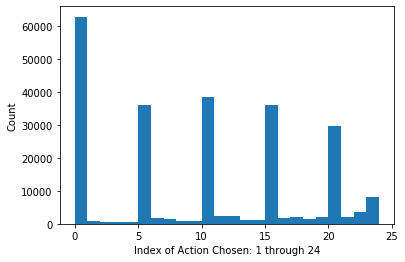

In [22]:
###
# FINISH CONSTRUCTION OF ALL ACTIONS AND THEIR VALUES
###

# Combine the columns that we desire to observe (iv_fluid_actions, vasopressor_actions)
iv_vaso_groups = pd.concat([iv_fluid_actions, vasopressor_actions], axis=1, sort=False)
# Name the columns for proper usage in the function
iv_vaso_groups.columns = ['iv_group', 'vasopressor_group']

action_keys, action_list = generate_action_matrix(iv_vaso_groups)

# Plot the distribution of actions
plt.hist(action_list, density=False, bins=24)  # `density=False` would make counts
plt.ylabel("Count")
plt.xlabel("Index of Action Chosen: 1 through 24")

In [23]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle
train_chosen_actions = []
with open ('sample_train.txt', 'rb') as fp:
    train_chosen_actions = pickle.load(fp)

# Grab a Series representing the action taken by the train data only
train_chosen_actions = pd.Series(action_list)[train_chosen_actions]

# Assign all action choices to their corresponding median values as shown previously
print(iv_median_actions, vasopressor_median_actions)

# Itertools provides an easy way to perform Cartesian product on multiple sets
from itertools import product as cartesian_prod

# This gives us the representative median values for a patient's vitals present in various action groups
# action_keys[i] corresponds to train_action_values[i]
# So, if the patient falls into group [1, 1] or no iv fluid given, no vasopressor administered,
# The corresponding median values for this group will be represented by train_action_values (0.0, 0.0).
# A patient in group [1, 2] (no iv fluid, a little vasopressor) will have a median real value of (0.0, 0.04)
train_action_values = list(cartesian_prod(iv_median_actions, vasopressor_median_actions))

if len(train_action_values) != len(iv_median_actions) * len(vasopressor_median_actions):
    print("Something went wrong in determining the Cartesian product")
    exit()

[0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] [0.0, 0.04, 0.135, 0.27, 0.7625]


In [24]:
###
# BEGIN CONSTRUCTION OF PRE-STATE MATRIX
# This will be used to build the full state/action matrix
### 

# Based on whether or not a patient is dead, we establish the range of possible values:
# If they have died, the range is [-100, 100]
# If they are alive, the range is [100, -100]
range_vals = [100, -100]
# Convert the range of values for a patient's status (dead or alive) from 0 or 1 to -1 or 1
# This will enable ranges to suit the above criteria [-100, 100] or [100, -100]
train_90d_polarity = (2 * (1 - train_90d) - 1)
range_matrix = [np.multiply(polarity, range_vals) for polarity in train_90d_polarity]
# Grab the lower range limit and upper range limit seperately in order to build the 
all_lower_ranges = [i[0] for i in range_matrix]
all_upper_ranges = [i[1] for i in range_matrix]
# The qlearning_dataset prior to modification contains 6 columns and ~190885 rows (around 75% of the data)
# The columns are as follows:
#
# training_bloc: time_series stamps for a patient's state over time, very in range from {1..?}
#
# closest_cluster_index: The index of the nearest cluster to the z-scores of the patient's data, 
# corresponding actual data for each cluster's index (i) can be found in cluster_values[i]
#
# chosen_action_index: The chosen action or representation of a patient's IV_Fluid and Vasopressor status [0 - 24]
# 
# 90d_morality_status: 0 means the patient is alive 90 days after discharge from ICU
#                      1 means the patient is dead  90 days after discharge from ICU
#
# lower_range + upper_range: An index to be used later on, gathered from the range index
print("Training Blocs Length: ", len(train_blocs), "Closest Clusters Length: ", len(closest_clusters[0]), "Action List Length: ", len(train_chosen_actions), "Train 90d Length", len(train_90d), "Range Matrix Length: ", len(range_matrix))
qlearning_dataset = pd.concat([pd.Series(train_blocs.tolist()), 
                               pd.Series(closest_clusters[0]), 
                               pd.Series(train_chosen_actions.tolist()), 
                               pd.Series(train_90d.tolist()), 
                               pd.Series(all_lower_ranges), 
                               pd.Series(all_upper_ranges)], 
                              axis=1, sort=False)
qlearning_dataset.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', '90d_morality_status', 'lower_range', 'upper_range']
print(qlearning_dataset)

Training Blocs Length:  189456 Closest Clusters Length:  189456 Action List Length:  189456 Train 90d Length 189456 Range Matrix Length:  189456
        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    133                    0   
1                   2                    133                    0   
2                   3                    386                    0   
3                   4                    386                    0   
4                   1                    563                   20   
...               ...                    ...                  ...   
189451              9                    452                    0   
189452             10                    176                    0   
189453             11                    219                    0   
189454             12                    547                    0   
189455             13                    547                    0   

        90d_morality_statu

In [25]:
# The base qlearning_dataset does not account for endpoints in either life or death
# These states have not been established yet, which is what this step corrects
qlearning_dataset_len = len(qlearning_dataset.index)
# We need space to add a death/life state for every patient, about a 20% increase in size from the original MDP
# We will cut the excess off by the end of the loop
qlearning_dataset_len_mod = int(np.floor(qlearning_dataset_len * 1.2))
qlearning_dataset_mod = np.array([[0 for i in range(0, 4)] for i in range(0, qlearning_dataset_len_mod)])

# Start construction of modified data
row = 0
# In Markov theory, an absorbing state is one which can be entered, but cannot be left. (Similar to the Hotel California)
# In the case of this experiment, those states are either life (state_count) or death (state_count + 1) per patient as
# defined by me
absorbing_states = [state_count, state_count + 1]

# Start the loop to begin capping the markov chain off at life and death states
for i in range(0, qlearning_dataset_len - 1):
    # Use the already gathered data for each row
    qlearning_dataset_mod[row, :] = qlearning_dataset.iloc[i][0:4]
    # If we arrive at the terminal point (end of patient data), we need to point the MDP to either the death or life state
    if qlearning_dataset.iloc[i + 1]['training_bloc'] <= qlearning_dataset.iloc[i]['training_bloc']:
        # Grab the row
        whole_row = qlearning_dataset.iloc[i]
        # Set most of the row to the original data's values, except set the action to be either state 750 or 751
        # Life or death respectively
        row = row + 1
        # We need bloc number, final state (life or death, 750 or 751), end action (-1), and the reward value (lower_range)
        qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_morality_status']], 25,  whole_row['lower_range']]
    row = row + 1
# Add in the last row
whole_row = qlearning_dataset.iloc[len(qlearning_dataset.index) - 1]
qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_morality_status']], 25,  whole_row['lower_range']]
row = row + 1
# Get rid of the unneeded rows
qlearning_dataset_mod = pd.DataFrame(qlearning_dataset_mod[0:row, :])
qlearning_dataset_mod.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', 'reward_value']

In [26]:
# Total patients being observed in the test
print(len(qlearning_dataset_mod[qlearning_dataset_mod['training_bloc'] == 1]['training_bloc']))
# Show that we now have end states established 
print(len(qlearning_dataset[qlearning_dataset['chosen_action_index'] == 25]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['chosen_action_index'] == 25]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] == 750]['chosen_action_index']))
print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] == 751]['chosen_action_index']))

17093
0
17093
13080
4013


In [100]:
###
#  Now that we officially have some a valid bloc for actions, and a valid set of states, it's time 
#  to begin building the transitions matrix.
### 

### If the matrix is bidirectional (S1 -> S2, S2 -> S1 are both valid, we can build two matrices)

### 
# The MDP Toolbox we are going to be using requires Transition and Reward Matrices to be in the form
# M(action, state1, state2)
###

###
# The create_transition_matrix method takes 4 arguments:
# num_actions: The total number of possible actions (calculated by action_count ^ 2 or in py, action_count ** 2)
# num_states:  Number of states the model uses
# qlearning_dataset: The dataset that will be used for the qlearning process
# transition_threshold: How many actions do we want to deem as scarce and not worth keeping (default = 5)
# reverse: If false, the matrix that is created is represented as transition[A][S1][S2], if true: transition[A][S2][S1]
###
def create_transition_matrix(num_actions, num_states, ql_data_input, transition_threshold = 5, reverse = False):
    # The transition matrix is a 3D construct, involving a transition between two states
    # and an action. The dimensions for the matrix are (state_count * 2) * (state_count + 2) * action_count
    transition_matrix = [[[0 for i in range(0, num_states + 2)] for i in range(0, num_states + 2)] for i in range(0, num_actions)]
    # NP Arrays allow for more compact and efficient slicing
    transition_matrix = np.array(transition_matrix).astype(float)
    # We also need a matrix to denote the policy that corresponds with taken a particular action from a state
    transition_policy_count = [[0 for i in range(0, num_states + 2 )] for i in range(0, num_actions)]
    transition_policy_count = np.array(transition_policy_count).astype(float)
    # Iterate over the actual data in order to form the actual states and their corresponding actions
    # As soon as we hit the next patient (the next row has a training bloc value of 1), we stop processing actions for that patient
    for i in range(0, len(qlearning_dataset_mod) - 1):
        # Since 1 is our 'endpoint' for each patient, there are no actions we can take from this point on
        if ql_data_input.iloc[i + 1]['training_bloc'] > ql_data_input.iloc[i]['training_bloc']:
            S1 = ql_data_input.iloc[i]['closest_cluster_index']
            S2 = ql_data_input.iloc[i + 1]['closest_cluster_index'] 
            action_id = ql_data_input.iloc[i]['chosen_action_index']
            if not(reverse):
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S1][S2] = transition_matrix[action_id][S1][S2] + 1
            else:
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S2][S1] = transition_matrix[action_id][S2][S1] + 1
                
            # Count the number of times action A is used to transition from S1
            transition_policy_count[action_id][S1] = transition_policy_count[action_id][S1] + 1        

    # In order to avoid drastically altering our model, we fix a constant
    # value (set by default to 5), in order to declare sparse actions 
    # as essentially not happening (make their count 0)
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if transition_policy_count[i][j] <= transition_threshold:
                transition_policy_count[i][j] = 0 
    # Now, we want to prevent transitions from state -> state using
    # a certain action if that action is sparse or nonexistant
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if not(reverse):
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,j,:] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,j,:] = transition_matrix[i,j,:]/np.float64(transition_policy_count[i][j])
            else:
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,:,j] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,:,j] = transition_matrix[i,:,j]/np.float64(transition_policy_count[i][j])
    
    # Ensure no divisions create NaNs or infinities
    transition_matrix = np.nan_to_num(transition_matrix)
    
    return transition_matrix

In [101]:
# Constructing Transition Matrix(A, State1, State2)
total_actions = action_count ** 2        
# Execute the function call
transition_mat = create_transition_matrix(total_actions, state_count, qlearning_dataset_mod, transition_threshold, False)
# Should be 25, 752, 752
print(len(transition_mat), len(transition_mat[0]), len(transition_mat[0][0]))

25 752 752


In [91]:
# Evaluate whether or not the Sum of all actions from a given state is either 0.0 or 1.0
# Where 1 indicates there are further actions to take, and 0 means we have hit the end of potential actions to take
for i in range(0, 25):
    for j in range(0, 752):
        total_prob = sum(transition_mat[i][j])
        if (abs(total_prob - 1.0) > 0.001):
            print("All probabilities should be either 0.0 or almost 1.0 (0.999....), check your arguments to transition_mat")

In [30]:
# State 750 is life, State 751 is death
# This provides a count of how many states in the finalized MDP end in life and death
life_count = 0
death_count = 0

for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        if transition_mat[i, j, 750] != 0:
            life_count = life_count + 1
        if transition_mat[i, j, 751] != 0:
            death_count = death_count + 1

print("Life Endpoints:", life_count, "\nDeath Endpoints", death_count)

Life Endpoints: 2779 
Death Endpoints 1885


In [31]:
# With the MDP built and the probabilities evaluated, it is time to construct the reward matrix 
reward_mat = np.array([[[0 for i in range(0, state_count + 2)] for i in range(0, state_count + 2)] for i in range(0, total_actions)])
# We want to fix initial penalities and rewards like before at -100 and +100
# Note, we allot the 2 extra columns for the reward and penalty
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        # If the patient hits the final state of death, we penalize the model
        reward_mat[i][j][state_count] = -100
        # If the patient hits the final state of life, we reward the model
        reward_mat[i][j][state_count + 1] = 100

In [32]:
# Perform Matrix multiplication to multiply reward value by probability of that reward
# This gives us the 'real reward' where sparse events are not weighted as heavily 
# as more frequent events.
# I.E
# An action that occurs 2% of the time resulting in death should suffer a much lower penalty than a death route that occurs 50% of the time
# Likewise, an action occurs 80% of the time yielding life should be looked at more closely than a 2% chance
# an action that incurse a 2%
reward_mat_final = np.multiply(transition_mat, reward_mat)

reward_count = 0
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        for k in range(0, state_count + 2):
            if reward_mat_final[i][j][k] != 0:
                reward_count = reward_count + 1
# Reward Count should be somewhere in the 2000 - 3500 count
print(reward_count)
            

# Validate that all rewards are in the range -100 to 100 
for i in range(0, total_actions):
    for j in range(0, state_count + 2):
        for k in range(0, state_count + 2):
            if reward_mat_final[i][j][k] > 100 or reward_mat_final[i][j][k] < -100:
                print("The entry at", i + "," + j, "has a reward value of ", reward_mat_other[i][j], "which is not in the range (-100, 100)")
                exit()

4664


In [103]:
###
#  The Full MDP is now finished. The Transition Matrix exists, the reward matrix that corresponds to it also exists.
#  Now is the time to actually perform Q-Learning
###

# The initial MDP matrix
# We need the values of weights that determines how much the model
# prefers transitioning from one state (medical conditional), to another
# The Matrix must be in the form [[A][S1][S2]] Where S1 is initial state, S2 is the second state, and
# A is the action taken to get from S1 to S2. 
transitions = transition_mat

# We need to determine the reward value for predicting an outcome leading to survival (+)
# and a penalty for an outcome that will yield death (-)
# The Matrix must be in the form [[R][S1][S2]] Where S1 is initial state, S2 is the second state, and
# R is the reward for taking the action from S1 to S2. 
reward = reward_mat_final

# We need to determine the discount value to influence the model to continue changing
# when outcomes are not desired, This value should be kept in the range 0 < discount < 1
discount = 1

# The Q-Learning algorithm will run a fixed number of times
numOfIterations = 10000

# We need to determine whether or not we want to validate that the transitions and rewards matrix
# to make sure they are valid, this option will only be turned off for speed
scheck = False



In [113]:
# MDP Toolbox (Built originally in MatLab) offers a nice way to perform Q-Learning on an Already Built MDP 
import mdptoolbox
ql_runner = mdptoolbox.mdp.QLearning(transitions, reward, discount, n_iter= numOfIterations)